In [1]:
global ROOT_DIR
ROOT_DIR = '/gpfs/commons/groups/gursoy_lab/aelhussein/ot_cost/otcost_fl_rebase'
global DATA_DIR
DATA_DIR = f'{ROOT_DIR}/data/ISIC'

In [291]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import sys
import json
from itertools import combinations
sys.path.append(f'{ROOT_DIR}/code/helper/')
import OTCost as ot
import importlib
importlib.reload(ot)
import torch
sys.path.append(f'{ROOT_DIR}/code/ISIC/')
import embedding as embed
import importlib
importlib.reload(embed)
import dataset
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader as dl
from sklearn.metrics.pairwise import cosine_similarity
from collections import OrderedDict


# EMBED IMAGES

In [300]:
BATCH_SIZE = 8

## Load model

In [ ]:
model = embed.Autoencoder(n_emb)
checkpoint = torch.load(f'{DATA_DIR}/model_checkpoint_{n_emb}.pth', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint)

In [ ]:
configs = vgg.get_configs('vgg16')
model = vgg.VGGAutoEncoder(configs)
checkpoint = torch.load(f'{ROOT_DIR}/code/ISIC/vgg_ae/imagenet-vgg16.pth', map_location=torch.device('cpu'))
new_state_dict = OrderedDict()
for key, value in checkpoint['state_dict'].items():
    if 'module.' in key:
        name = key[7:] # remove 'module.' prefix
    else:
         name = key 
    new_state_dict[name] = value
model.load_state_dict(new_state_dict)

<All keys matched successfully>

## Visualise data

In [ ]:
train_data = dataset.FedIsic2019(train=True, pooled = True, data_path=DATA_DIR)
val_data = dataset.FedIsic2019(train=False, pooled = True, data_path=DATA_DIR)
train_loader = dl(train_data, batch_size = BATCH_SIZE, shuffle = True)
val_loader = dl(val_data, batch_size = BATCH_SIZE, shuffle = True)

In [ ]:
def visualize(images, reconstructed_images):
    n = images.shape[0]
    for i in range(n):
        img1 = images[i, :, :, :].detach()
        img2 = reconstructed_images[i, :, :, :].detach()

        img1 = np.array(img1).transpose(1,2,0) * 255
        img1 = (img1).astype('uint8')

        img2 = np.array(img2).transpose(1,2,0) * 255
        img2 = (img2).astype('uint8')

        # Plotting the images
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(img1)
        axes[0].set_title('True Image')
        axes[1].imshow(img2)
        axes[1].set_title('Reconstructed Image')

    plt.show()

In [ ]:
image, _, _ = next(iter(train_loader))
image = image.transpose(2,1)
reconstructed = model(image)

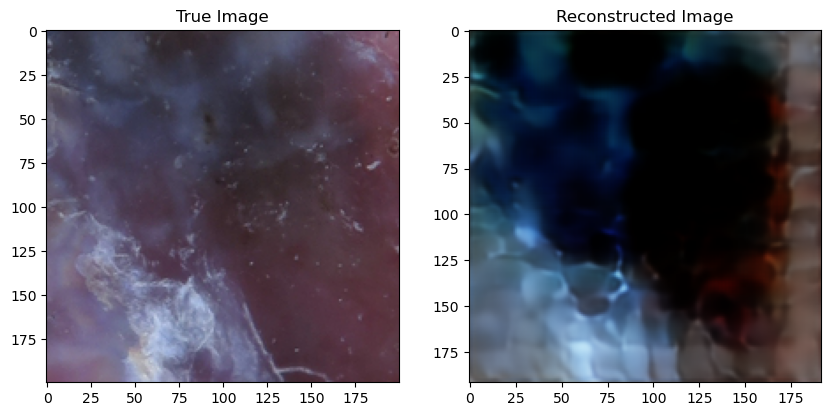

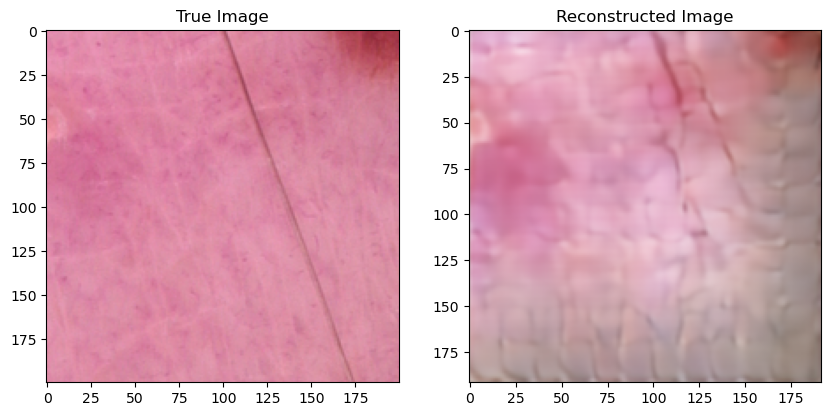

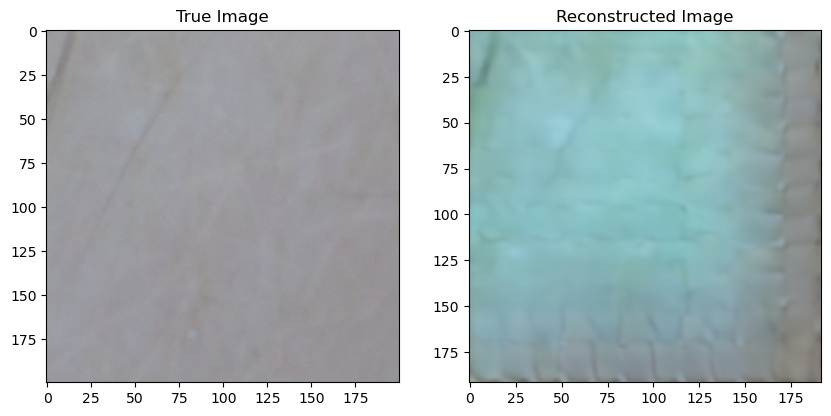

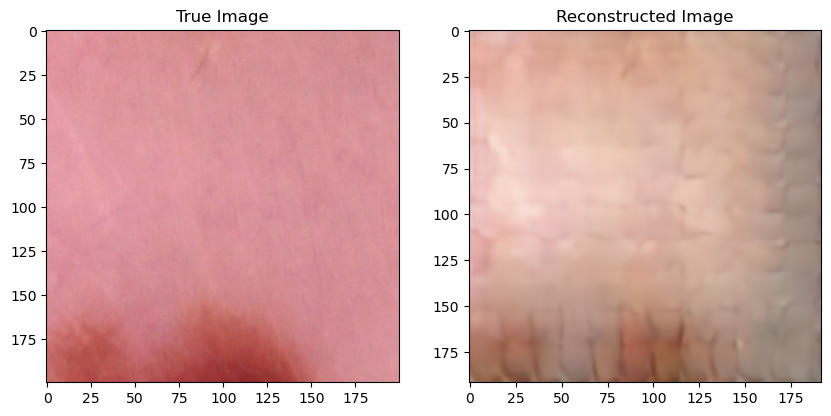

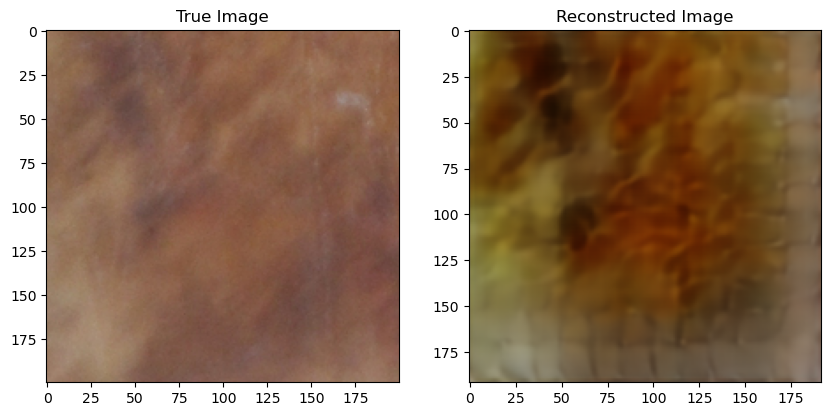

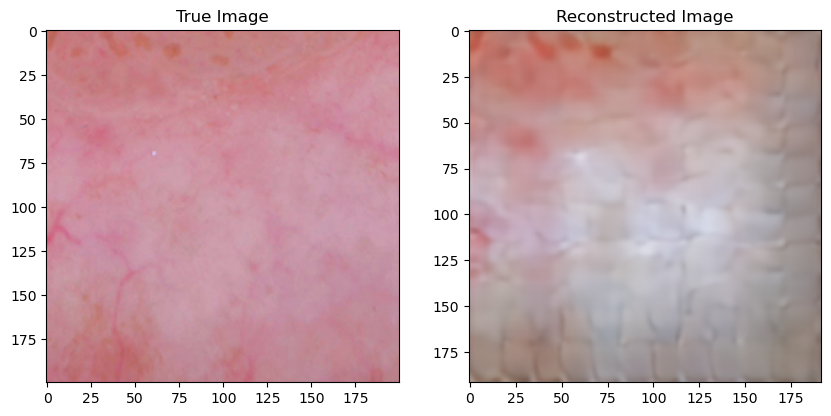

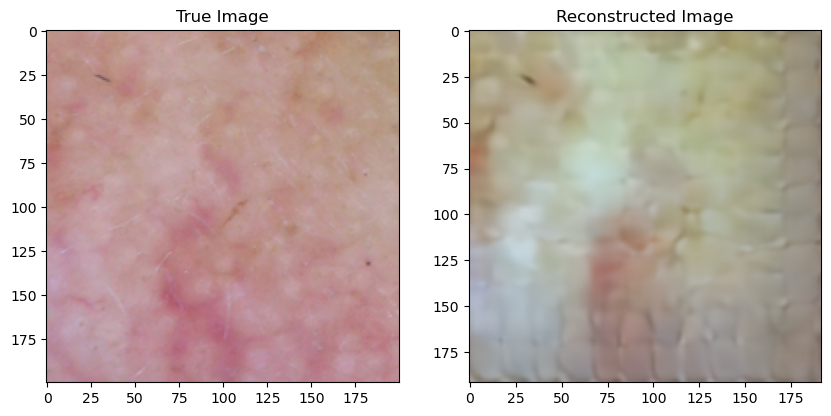

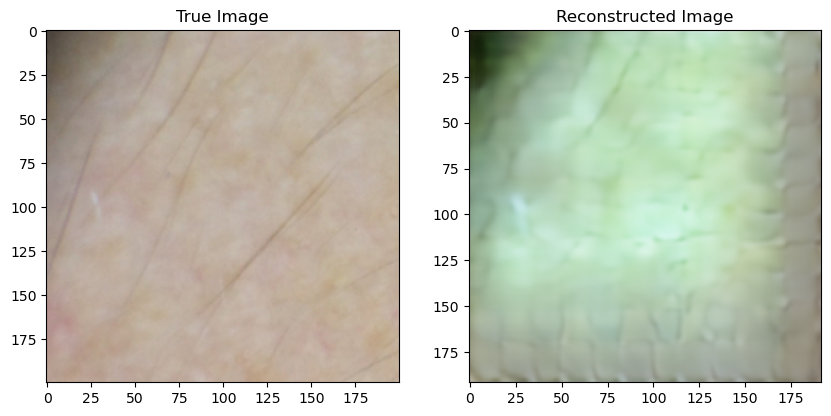

In [ ]:
visualize(image, reconstructed)

## Create embeddings

In [ ]:
def extract_embedding(image):
    B = image.shape[0]
    with torch.no_grad():
        image = image.transpose(2,1)
        embedding = model(image, embedding = True)
        return embedding.reshape(B,-1).detach()

In [ ]:
def create_embedding(loader, center):
    labels_list = []
    names_list = []
    count = 0
    for images, labels, paths in loader:
        embeddings = extract_embedding(images)
        image_names = [p.split('/')[-1].split('.')[0] for p in paths]
        names_list.extend(image_names)
        emb_paths = [f'{DATA_DIR}/embedding/center_{center}_{image_name}' for image_name in image_names]
        for i in range(len(emb_paths)):
            emb_save = embeddings[i].numpy()
            emb_path = emb_paths[i]
            np.save(emb_path, emb_save)
            count += 1
        labels_list.append(labels)   
        if count > 1000:
            break
    all_labels = (torch.cat(labels_list, dim=0)).numpy()
    labels_df = pd.DataFrame({
                    "Name": names_list,
                    "Label": all_labels
                })
    labels_df.to_csv(f'{DATA_DIR}/center_{center}_labels.csv', index = False)
    return

In [ ]:
sites_loaders = {}
for i in range(1,6):
    train_data = dataset.FedIsic2019(center = i, train=True, pooled = False, data_path=DATA_DIR)
    val_data = dataset.FedIsic2019(center = i, train=False, pooled = False, data_path=DATA_DIR)
    train_loader = dl(train_data, batch_size = BATCH_SIZE, shuffle = True)
    val_loader = dl(val_data, batch_size = BATCH_SIZE, shuffle = True)
    sites_loaders[i]= (train_loader, val_loader)

In [ ]:
for i in range(1,6):
    train_loader, val_loader = sites_loaders[i]
    create_embedding(train_loader, center = i)
    #create_embedding(val_loader, center = i)

# Create embedding datasets to calculate cost

In [241]:
NUM_SAMPLES = 1000
files = os.listdir(f'{DATA_DIR}/embedding')
sites = [i for i in range(6)]
site_samples = {}
site_embeddings = {}
site_labels = {}
for site in sites:
    sites_files = [file for file in files if f'center_{site}' in file]
    sites_files = np.random.choice(sites_files, size = NUM_SAMPLES)
    site_samples[site] = sites_files
    names = [f.split(f'center_{site}_')[-1].split('.npy')[0] for f in sites_files]
    labels_site = pd.read_csv(f'{DATA_DIR}/center_{site}_labels.csv', index_col = 'Name')
    labels_site = labels_site.loc[names]
    site_labels[site] = labels_site['Label'].values

for site, files in site_samples.items():
    embeddings = [np.load(f'{DATA_DIR}/embedding/{file}') for file in files]
    site_embeddings[site] = np.array(embeddings)

# Measure OT cost

In [298]:
def create_dictionaries(site_embeddings, site_labels, sites, NUM_SAMPLES = 500):
    data = {'1': site_embeddings[sites[0]][:NUM_SAMPLES], '2' :site_embeddings[sites[1]][:NUM_SAMPLES]}
    labels = {'1': site_labels[sites[0]][:NUM_SAMPLES], '2': site_labels[sites[1]][:NUM_SAMPLES]}
    data, labels = remove_rare_labels(data, labels, min_count = 30)
    return data, labels

#Function is needed as estimating label cost with fewer data points leads to degeneracy
def remove_rare_labels(data, labels, min_count):
    for key in labels:
        unique_labels, counts = np.unique(labels[key], return_counts=True)
        labels_to_remove = unique_labels[counts <= min_count]
        mask = np.isin(labels[key], labels_to_remove, invert=True)
        labels[key] = labels[key][mask]
        data[key] = data[key][mask]
    return data, labels


In [321]:
DATASET = 'ISIC'
NUM_SAMPLES = 500

In [322]:
importlib.reload(ot)
sites = [i for i in range(6)]
site_pairs = list(combinations(sites, r = 2))
results = {}
#Between site cost calculation
for pair in site_pairs:
    data, labels = create_dictionaries(site_embeddings, site_labels, pair, NUM_SAMPLES)
    ISIC_OTCost_label = ot.OTCost(DATASET, data, labels)
    cost = ISIC_OTCost_label.calculate_ot_cost()
    cost = "{:.2f}".format(float(cost))
    results[pair] = cost

#Same site cost calculation
for site in range(6):
    data = {'1': site_embeddings[site][:NUM_SAMPLES], '2' :site_embeddings[site][NUM_SAMPLES:]}
    labels = {'1': site_labels[site][:NUM_SAMPLES], '2': site_labels[site][NUM_SAMPLES:]}
    data, labels = remove_rare_labels(data, labels, min_count = 30)
    ISIC_OTCost_label = ot.OTCost(DATASET, data, labels)
    cost = ISIC_OTCost_label.calculate_ot_cost()
    results[site] = cost


cost: 0.22
cost: 0.18
cost: 0.19
cost: 0.17
cost: 0.21
Degenerate label calculation, reducing vector dimensions
cost: 0.23
Degenerate label calculation, reducing vector dimensions
cost: 0.31
cost: 0.28
cost: 0.16
Degenerate label calculation, reducing vector dimensions
Degenerate label calculation, reducing vector dimensions


/gpfs/commons/home/aelhussein/anaconda3/envs/torch_env/lib/python3.10/site-packages/ot/bregman.py:1112: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


cost: 0.19
cost: 0.19
cost: 0.19
cost: 0.22
cost: 0.28
cost: 0.24


/gpfs/commons/home/aelhussein/anaconda3/envs/torch_env/lib/python3.10/site-packages/ot/bregman.py:1112: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


cost: 0.08
cost: 0.06
Degenerate label calculation, reducing vector dimensions


/gpfs/commons/home/aelhussein/anaconda3/envs/torch_env/lib/python3.10/site-packages/ot/bregman.py:1112: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


cost: 0.10


/gpfs/commons/home/aelhussein/anaconda3/envs/torch_env/lib/python3.10/site-packages/ot/bregman.py:1112: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


cost: 0.11


/gpfs/commons/home/aelhussein/anaconda3/envs/torch_env/lib/python3.10/site-packages/ot/bregman.py:1112: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


cost: 0.07
Degenerate label calculation, reducing vector dimensions
Degenerate label calculation, reducing vector dimensions
cost: 0.06


/gpfs/commons/home/aelhussein/anaconda3/envs/torch_env/lib/python3.10/site-packages/ot/bregman.py:1112: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


In [323]:
results_df = pd.DataFrame.from_dict(results, orient = 'index', columns = ['Cost'])
results_df['Cost']  = pd.to_numeric(results_df['Cost'])
results_df


,Cost
"(0, 1)",0.220000
"(0, 2)",0.180000
"(0, 3)",0.190000
"(0, 4)",0.170000
"(0, 5)",0.210000
"(1, 2)",0.230000
"(1, 3)",0.310000
"(1, 4)",0.280000
"(1, 5)",0.160000
"(2, 3)",0.190000


In [325]:
results_df.to_csv(f'{ROOT_DIR}/results/ISIC/dataset_ot_costs.csv')